In [6]:
df=pd.read_excel('Data/Snappfood - Sentiment Analysis.xlsx')

In [7]:
df=df[['comment','label']]
df.head()

,comment,label
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY


In [8]:
le=LabelEncoder()

df['label']=le.fit_transform(df['label'])


## Preprocessing

In [9]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())

def preprocess(text):

    text = normalizer.normalize(text)

    # Remove Latin chars, digits, symbols, emojis, and punctuation
    text = re.sub(r'[\u0000-\u007F\u200c\u200f]', ' ', text)  
    text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)

    # Remove repeating characters (e.g. خخخخ or عالییییی)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    lemmatized = [
        lemmatizer.lemmatize(token) for token in tokens
        if token not in stopwords and len(token) > 1
    ]

    return ' '.join(lemmatized)


In [10]:
df['clean_comment'] = df['comment'].astype(str).swifter.apply(preprocess)

Pandas Apply: 100%|██████████| 70000/70000 [00:22<00:00, 3085.57it/s]


In [12]:
df.to_csv('Data/cleaned_reviews.csv',index=False)

In [13]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df['clean_comment'])
y=df['label']

## Model training

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

lr=LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

pred=lr.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      6982
           1       0.80      0.85      0.82      7018

    accuracy                           0.82     14000
   macro avg       0.82      0.82      0.82     14000
weighted avg       0.82      0.82      0.82     14000



In [15]:
model = xgb.XGBClassifier(eval_metric="mlogloss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.78      0.80      6982
           1       0.79      0.83      0.81      7018

    accuracy                           0.80     14000
   macro avg       0.80      0.80      0.80     14000
weighted avg       0.80      0.80      0.80     14000



In [16]:
rnd_clf=RandomForestClassifier()
rnd_clf.fit(X_train,y_train)

y_pred=rnd_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      6982
           1       0.78      0.86      0.82      7018

    accuracy                           0.81     14000
   macro avg       0.81      0.81      0.81     14000
weighted avg       0.81      0.81      0.81     14000



## Deep learning

In [18]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()
stopwords = set(stopwords_list())

def preprocess2(text):
    text = normalizer.normalize(text)

    # Convert English digits to Persian (optional for user-generated content)
    text = re.sub(r'\d+', '', text)

    # Preserve key punctuation (!, ؟) that conveys emotion
    text = re.sub(r'[^\u0600-\u06FF\u061F\u0621\s!؟]', ' ', text)

    # Normalize stretched text: عالییییی → عالی
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    tokens = word_tokenize(text)

    # Filter + stem + lemmatize
    processed = []
    for token in tokens:
        if token not in stopwords and len(token) > 1:
            stemmed = stemmer.stem(token)
            lemma = lemmatizer.lemmatize(stemmed)
            processed.append(lemma)

    return ' '.join(processed)


In [19]:
df['clean_comment'] = df['comment'].astype(str).swifter.apply(preprocess2)

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(df['clean_comment'])

# Sequences
sequences = tokenizer.texts_to_sequences(df['clean_comment'])

# Smart max length (95th percentile)
lengths = [len(seq) for seq in sequences]
maxlen = int(np.percentile(lengths, 95))

X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = df['label']


Pandas Apply: 100%|██████████| 70000/70000 [00:23<00:00, 2966.12it/s]


In [20]:
df.to_csv('Data/deepLearning_cleaned_data.csv',index=False)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:

vocab_size = len(tokenizer.word_index) + 1

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


c:\Users\Fardin Piroozi\.conda\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 67s 31ms/step - accuracy: 0.6902 - loss: 0.6230 - val_accuracy: 0.8184 - val_loss: 0.4328
Epoch 2/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - accuracy: 0.8290 - loss: 0.4196 - val_accuracy: 0.8233 - val_loss: 0.4102
Epoch 3/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.8424 - loss: 0.3858 - val_accuracy: 0.8224 - val_loss: 0.4045
Epoch 4/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - accuracy: 0.8481 - loss: 0.3649 - val_accuracy: 0.8214 - val_loss: 0.4036
Epoch 5/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.8553 - loss: 0.3485 - val_accuracy: 0.8209 - val_loss: 0.4071
Epoch 6/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - accuracy: 0.8629 - loss: 0.3337 - val_accuracy: 0.8204 - val_loss: 0.4121
Epoch 7/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 57s 29ms/step - accuracy: 0.8696 - loss: 0.3186 - val_accuracy: 0.8154 - val_loss: 0.4213


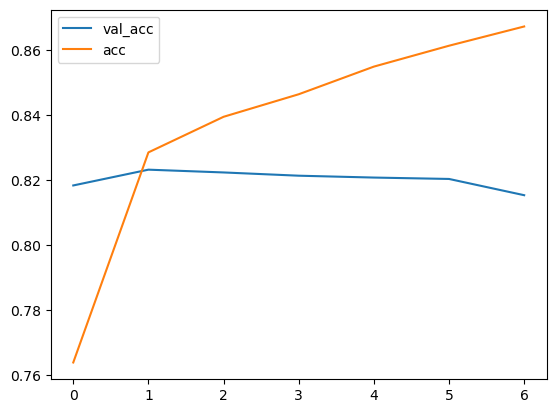

In [25]:
plt.figure()
plt.plot(pd.DataFrame(history.history['val_accuracy']),label='val_acc')
plt.plot(pd.DataFrame(history.history['accuracy']),label='acc')
plt.legend()
plt.show()

In [26]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.3f}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8250 - loss: 0.3990
Test Accuracy: 0.821


In [27]:
# the best model so far is the LogisticRegression
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(lr, "sentiment_model.pkl")

['sentiment_model.pkl']